# Fatima Fellowship Quick Coding Challenge (Pick 1)

Thank you for applying to the Fatima Fellowship. To help us select the Fellows and assess your ability to do machine learning research, we are asking that you complete a short coding challenge. Please pick **1 of these 5** coding challenges, whichever is most aligned with your interests. 

**Due date: 1 week**

**How to submit**: Please make a copy of this colab notebook, add your code and results, and submit your colab notebook to the submission link below. If you have never used a colab notebook, [check out this video](https://www.youtube.com/watch?v=i-HnvsehuSw).

**Submission link**: https://airtable.com/shrXy3QKSsO2yALd3

# 1. Deep Learning for Vision

**Upside down detector**: Train a model to detect if images are upside down

* Pick a dataset of natural images (we suggest looking at datasets on the [Hugging Face Hub](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads))
* Synthetically turn some of images upside down. Create a training and test set.
* Build a neural network (using Tensorflow, PyTorch, or any framework you like)
* Train it to classify image orientation until a reasonable accuracy is reached
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* Look at some of the images that were classified incorrectly. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

**Submission instructions**: Please write your code below and include some examples of images that were classified

In [1]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

In [2]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve
import albumentations as A
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms


In [3]:
from albumentations.pytorch import ToTensor

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
cudnn.benchmark = True

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
cd /content/drive/MyDrive/upside_down

/content/drive/MyDrive/upside_down


In [7]:
!pip install datasets

     |████████████████████████████████| 325 kB 5.3 MB/s 
     |████████████████████████████████| 212 kB 45.4 MB/s 
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 1.1 MB 40.0 MB/s 
     |████████████████████████████████| 136 kB 45.8 MB/s 
     |████████████████████████████████| 127 kB 49.4 MB/s 
     |████████████████████████████████| 94 kB 3.6 MB/s 
     |████████████████████████████████| 271 kB 49.0 MB/s 
     |████████████████████████████████| 144 kB 51.2 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [8]:
from datasets import load_dataset
dataset = load_dataset("cifar100")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar100 downloaded and prepared to /root/.cache/huggingface/datasets/cifar100/cifar100/1.0.0/f365c8b725c23e8f0f8d725c3641234d9331cd2f62919d1381d1baa5b3ba3142. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
from PIL import Image
train_sample = dataset["train"]
train_sample

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 50000
})

In [10]:
from PIL import Image

In [11]:
train_sample = dataset["train"]
train_sample

Dataset({
    features: ['img', 'fine_label', 'coarse_label'],
    num_rows: 50000
})

In [12]:
test_sample = dataset["test"]

In [13]:
test_sample[0]['fine_label']

49

Datsaet

In [14]:
class DatasetClass(Dataset):
    def __init__(self, dataset, field='image', transform=None): #data_indices
        self.dataset = dataset
        # self.data_labeled_indices = data_indices
        self.field = field
        self.transform = transform
        
    def __len__(self):
        return self.dataset.num_rows

    def __getitem__(self, idx):
        # image_idx, label = self.data_labeled_indices[idx]
        label = random.randint(0,1)
        image = self.dataset[idx][self.field]
        
        # 0 = normal image
        if label == 0:
            image = self.transform(image)
            label = torch.tensor(label) #ToTensor()(label)
            
            # encountered a single channel image in food dataset
            # if image.shape[0]==3:
            #     return image, label
            # else:
            #     image = [image]*3
            return image, label
        # 1 = flipped image/upside down
        else:
            flipped_image = image.transpose(Image.FLIP_TOP_BOTTOM)
            flipped_image = self.transform(flipped_image)
            label = torch.tensor(label) #ToTensor()(label)
            return flipped_image, label

### Standarization

In [15]:
normalize = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                                 ])

In [16]:
train_data = DatasetClass(dataset['train'], field='img', transform=normalize)
test_data = DatasetClass(dataset['test'], field='img',  transform=normalize)

In [17]:
x_train, y_train = train_data[3]
x_train.shape

torch.Size([3, 32, 32])

### Loading Data

In [18]:
params = {
    "model": "resnet18",
    "feature_dimension": 512,
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "num_workers": 4,
    "epochs": 25,
}


In [19]:
train_dataloader = DataLoader(train_data, batch_size=params['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=params['batch_size'], shuffle=False)

In [20]:
stream = next(iter(train_dataloader))
x, y = stream
x.shape

torch.Size([128, 3, 32, 32])

### Pretrained MOdel

In [21]:
class CustomPretrainedModel(nn.Module):
    def __init__(self, model_name=params["model"], feature_dim=params["feature_dimension"], class_number=1):
        super(CustomPretrainedModel, self).__init__()
        self.model_name = model_name
        self.feature_dim = feature_dim
        self.class_number = class_number
        self.ready_model = self.model_return()

    def model_return(self):
        pre_model = getattr(models, self.model_name)(pretrained=True)
        print(pre_model)
        pre_model.fc = nn.Identity()
        pre_model.fc = nn.Linear(in_features=self.feature_dim, out_features=self.class_number, bias=True)
        return pre_model

    def forward(self, x):
        output = self.ready_model(x)
        return output


In [22]:
ready_model = CustomPretrainedModel()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [23]:
output = ready_model(x)
output.shape

torch.Size([128, 1])

In [24]:
ready_model

CustomPretrainedModel(
  (ready_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affi

In [25]:
def calculate_accuracy(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [26]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


In [27]:
model = ready_model.to(params["device"])
criterion = nn.BCEWithLogitsLoss().to(params["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])


### Training pipeline

In [28]:
def train(train_loader, model, criterion, optimizer, epoch, params):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, target)
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        # train_losses.append(loss.item())
        metric_monitor.update("Accuracy", accuracy)
        # train_acc.append(accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg'] #loss.item(), accuracy


### Validation

In [29]:
def validate(val_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            # val_losses.append(loss.item())
            metric_monitor.update("Accuracy", accuracy)
            # val_acc.append(accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return metric_monitor.metrics['Loss']['avg'], metric_monitor.metrics['Accuracy']['avg'] #loss.item(), accuracy



In [33]:
def model_save(epoch, model, optimizer, PATH):
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, PATH)



### Training Loop

In [31]:
import matplotlib.pyplot as plt

In [34]:
train_losses = []
train_acc = []

val_losses = []
val_acc = []

prev_accuracy = 0
for epoch in range(1, params["epochs"] + 1):
    train_loss, train_accuracy = train(train_dataloader, model, criterion, optimizer, epoch, params)
    val_loss, val_accuracy = validate(test_dataloader, model, criterion, epoch, params)
    # print("##########", train_loss, val_loss)
    # print("!!!!!!!!!", train_accuracy, val_accuracy)

    # if val_accuracy > prev_accuracy:
    model_save(epoch, model, optimizer, PATH = f"/content/drive/MyDrive/upside_down/my_model_epoch_{epoch}.pth")

    prev_accuracy = val_accuracy

    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

Epoch: 1. Train.      Loss: 0.428 | Accuracy: 0.791: 100%|██████████| 391/391 [00:57<00:00,  6.85it/s]
Epoch: 1. Validation. Loss: 0.426 | Accuracy: 0.796: 100%|██████████| 79/79 [00:09<00:00,  7.98it/s]
Epoch: 2. Train.      Loss: 0.371 | Accuracy: 0.825: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]
Epoch: 2. Validation. Loss: 0.426 | Accuracy: 0.799: 100%|██████████| 79/79 [00:09<00:00,  8.00it/s]
Epoch: 3. Train.      Loss: 0.321 | Accuracy: 0.854: 100%|██████████| 391/391 [00:57<00:00,  6.80it/s]
Epoch: 3. Validation. Loss: 0.430 | Accuracy: 0.804: 100%|██████████| 79/79 [00:09<00:00,  8.10it/s]
Epoch: 4. Train.      Loss: 0.277 | Accuracy: 0.878: 100%|██████████| 391/391 [00:55<00:00,  7.08it/s]
Epoch: 4. Validation. Loss: 0.447 | Accuracy: 0.801: 100%|██████████| 79/79 [00:09<00:00,  7.98it/s]
Epoch: 5. Train.      Loss: 0.243 | Accuracy: 0.895: 100%|██████████| 391/391 [00:58<00:00,  6.68it/s]
Epoch: 5. Validation. Loss: 0.443 | Accuracy: 0.813: 100%|██████████| 79/79 [00:0

KeyboardInterrupt: ignored

### Training and validation Accurancy

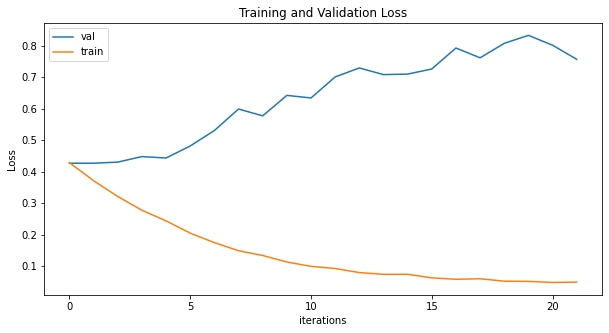

In [35]:
############ Curve ############
plt.figure(figsize=(10,5))
plt.title("Training and Validation Loss")
plt.plot(val_losses,label="val")
plt.plot(train_losses,label="train")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('/content/drive/MyDrive/upside_down/images/train_and_val_loss_resnet18.jpg')
plt.show()

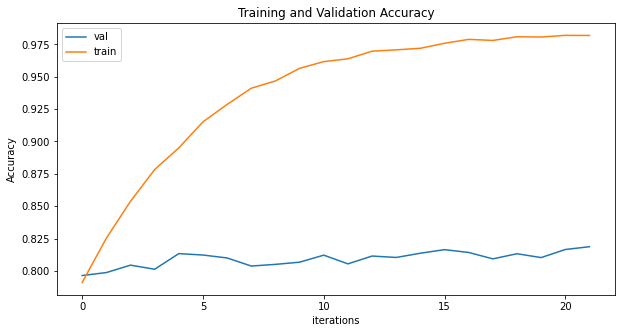

In [37]:
plt.figure(figsize=(10,5))
plt.title("Training and Validation Accuracy")
plt.plot(val_acc,label="val")
plt.plot(train_acc,label="train")
plt.xlabel("iterations")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig('/content/drive/MyDrive/upside_down/images/train_and_val_acc_resnet18.jpg')
plt.show()

### Loading Model

In [42]:
model_path = "/content/drive/MyDrive/upside_down/my_model_epoch_20.pth"

In [43]:
checkpoint = torch.load(model_path, map_location=params['device'])

In [44]:
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']

### Inference pipeline

In [45]:
dataset = load_dataset("cifar10")

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [46]:
inference_indices = [(i, random.randint(0,1)) for i in range(dataset['train'].num_rows)]

In [47]:
inferece_transform =  transforms.Compose([transforms.Lambda(lambda image: image.convert('RGB')), transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                                 ])

In [48]:
inference_data = DatasetClass(dataset['train'], field='img', transform=inferece_transform)

In [49]:
inference_dataloader = DataLoader(inference_data, batch_size=params['batch_size'], shuffle=False)

### Test Accurancy

In [50]:
from sklearn.metrics import f1_score, precision_score

In [51]:
def calculate_metrics(output, target):
    output = torch.sigmoid(output) >= 0.5
    target = target == 1.0
    target = target.cpu()
    output = output.cpu()
    
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item(), f1_score(target, output), precision_score(target, output)

In [52]:
def test(test_loader, model, criterion, epoch, params):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(test_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, target)
            accuracy = calculate_accuracy(output, target)
            accuracy, f1_score_var, precision = calculate_metrics(output, target)
            # print(accuracy, f1_score_var, precision)
            # break
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            metric_monitor.update("F1-Score", f1_score_var)
            metric_monitor.update("Precision-", precision)
            stream.set_description(
                "Epoch: {epoch}. Test. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    return accuracy, f1_score


In [54]:
test_accuracy, _ = test(inference_dataloader, model, criterion, epoch, params)

Epoch: 20. Test. Loss: 0.841 | Accuracy: 0.814 | F1-Score: 0.812 | Precision-: 0.821: 100%|██████████| 391/391 [01:01<00:00,  6.40it/s]




### Test Accuracy:

   - I have tested the inference dataset using 'cifar10' and it's working perfectly and got accuracy almost 82% using the highest validtion accuracy model name 'my_model_epoch_6.pth' where Dropout has been used with resnet18 pretrained model before the linear layer(modified the out_feature=1).

   - As you can see almost 82% of the 'cifar10' dataset has been predicted true but almost 18% of the dataset has been predicted wrong but this can be improved. Most of the models are being overfitted but I have chosen a best fitted model among the other models/epoch.

##### The models are becoming bias on human images.
- I have also tested 'food101' dataset in inference time but the models couldn't predict the right image because 'cifar100' doesn't have food images.
 -   I also have try to label the images randomly during training time that helped me to get some more accuracy.
 -  If I use dropout in every layer then it might be possible that the train and test accuracy will increase.
-  I also trained models in resnet34 and resnet50 but got very bad result.
 -  At last I have trained the model using resnet18 without Dropout but using the random labeling on the fly and got best results till now.
- In epoch-24 the train and validation accuracy is consecutively 0.991 and 0.906 and inference accuracy is 99.4% on 'cifar10' dataset which is till now best accuracy I have gotten. 



### Testing Image

In [55]:
from PIL import Image

In [56]:
inferece_transform_visual =  transforms.Compose([transforms.Lambda(lambda image: image.convert('RGB')), transforms.Resize((32,32)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
                                 ])




Image Prediction:

- If the tensor is negetive or 0 then the image is "Normal image" and it will Predict "False".

- If the tensor is possitive then the image is "upside down" and it will Predict "True".



tensor([[-18.3507]], device='cuda:0', grad_fn=<AddmmBackward0>)
[False]


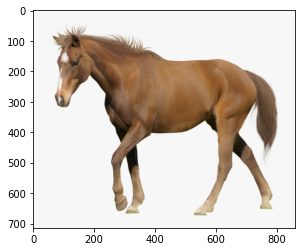

In [59]:
image_for_inference = Image.open('/content/drive/MyDrive/upside_down/images/cheval.png')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = inferece_transform_visual(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(output)
print(predictions)

tensor([[10.1964]], device='cuda:0', grad_fn=<AddmmBackward0>)
[ True]


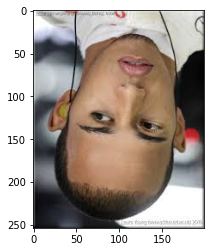

In [60]:
image_for_inference = Image.open('/content/drive/MyDrive/upside_down/images/homme.jpeg')
# image_for_inference = image_for_inference.resize((32,32))
plt.imshow(image_for_inference)
image_for_inference = inferece_transform_visual(image_for_inference)
model.eval()
output = model(image_for_inference.float().unsqueeze(0).to(params["device"], non_blocking=True))
predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
print(output)
print(predictions)

**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified images. Please explain what you might do to improve your model's performance on these images in the future (you do not need to impelement these suggestions)

# 2. Deep Learning for NLP

**Fake news classifier**: Train a text classification model to detect fake news articles!

* Download the dataset here: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset
* Develop an NLP model for classification that uses a pretrained language model
* Finetune your model on the dataset, and generate an AUC curve of your model on the test set of your choice. 
* [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.
* *Answer the following question*: Look at some of the news articles that were classified incorrectly. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

In [1]:
##import all necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import sklearn
import re
import string
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [ ]:
! pip install kaggle

In [ ]:
mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/admin:///root/.kaggle

cp: cannot stat 'kaggle.json': No such file or directory


In [ ]:
! sudo chmod 600 admin:///root/kaggle.json

chmod: cannot access 'admin:///root/kaggle.json': No such file or directory


In [ ]:
! kaggle datasets download -d clmentbisaillon/fake-and-real-news-dataset

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python3.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python3.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 166, in authenticate
    self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! unzip fake-and-real-news-dataset.zip

unzip:  cannot find or open fake-and-real-news-dataset.zip, fake-and-real-news-dataset.zip.zip or fake-and-real-news-dataset.zip.ZIP.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
true_df = pd.read_csv("/content/drive/MyDrive/True.csv")
fake_df = pd.read_csv("/content/drive/MyDrive/Fake.csv")

In [4]:
!pip install transformers

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 77 kB 2.9 MB/s 
     |████████████████████████████████| 596 kB 39.2 MB/s 
     |████████████████████████████████| 895 kB 44.9 MB/s 
     |████████████████████████████████| 6.6 MB 41.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [5]:
!pip install scikit-plot

In [6]:
import os
import gc
import copy
import time
import random
import string
import re

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


# Utils
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve
# Compute ROC curve and ROC area for each class
import scikitplot as skplt

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AdamW
from transformers import AutoConfig
from transformers import get_scheduler



# visualization 
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline
# NLP libraries as NLTK
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
# adding label
true_df["label"] = [1]*len(true_df) 
fake_df["label"] = [0]*len(fake_df)



In [11]:
# concatenate true & fake articles together
df = pd.concat([true_df, fake_df]).sample(frac=1).reset_index(drop=True)
# # drop duplicates
df.drop_duplicates(inplace=True)

# empty rows
df.dropna(inplace=True)



In [12]:
## Extract Year from Data column
df['year']=df['date'].str[-5:]

In [13]:
df['year'].unique()

array(['2016 ', ' 2017', '2017 ', ' 2016', ' 2015', 'eb-18', 'd.jpg',
       'ideo]', 'left/', 'dier/', 't.jpg', '-pie/'], dtype=object)

Text(0, 0.5, 'Distribution of words in the news text')

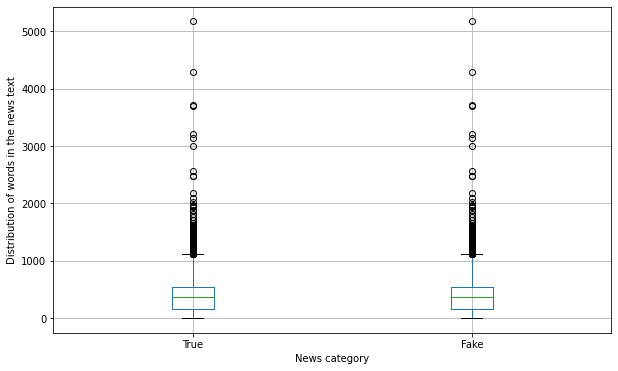

In [14]:
# get number of words in the data
def text_length(text):
    word_count = 0
    for word in text.split(" "):
        word_count += 1
    return word_count

true_words_count = true_df['text'].apply(text_length)
fake_words_count = fake_df['text'].apply(text_length)

words_count = pd.DataFrame({'True': true_words_count, 'Fake': true_words_count})

plt.figure(figsize=(10, 6))
words_count.boxplot()
plt.xlabel('News category')
plt.ylabel('Distribution of words in the news text')

In [15]:
stopwords = stopwords.words('english')


# create a corpuse of words in the data.
def create_corpuse(data, column_name):
    words_by_frequency = defaultdict(int)

    for title in data['{0}'.format(column_name)]:
        for word in title.lower().split(' '):
            if word not in stopwords:
                words_by_frequency[word] += 1

    return sorted(words_by_frequency.items(), key=lambda x: x[1], reverse=True)

counter_words_title_true = create_corpuse(true_df, 'title')
counter_words_title_fake = create_corpuse(fake_df, 'title')

counter_words_text_true = create_corpuse(true_df, 'text')
counter_words_text_fake = create_corpuse(fake_df, 'text')



In [16]:
# some popular news agencies names 
# get the number of 'element' in the data
def find_text_elements(data, column_name, element):
    count_element = 0
    re_element = re.compile(element)
    for text in data['{0}'.format(column_name)]:
        count_element += len(re.findall(re_element, text.lower()))
    return count_element

articles = {'the washington post': [0, 0], 'cnn': [0, 0], 'bbc': [0, 0], 'reuters': [0, 0], 
            'fox news': [0, 0], 'the new york times': [0, 0], 'nbc': [0, 0]}
for key, _ in articles.items():
    true_value = find_text_elements(true_df, 'text', element=key)
    fake_value = find_text_elements(fake_df, 'text', element=key)
    articles[key] = true_value, fake_value
    



articles_count = pd.DataFrame(articles)

In [17]:
articles = {'the washington post': [0, 0], 'cnn': [0, 0], 'bbc': [0, 0], 'reuters': [0, 0], 
            'fox news': [0, 0], 'the new york times': [0, 0], 'nbc': [0, 0]}
for key, _ in articles.items():
    true_value = find_text_elements(true_df, 'title', element=key)
    fake_value = find_text_elements(fake_df, 'title', element=key)
    articles[key] = true_value, fake_value
articles_count = pd.DataFrame(articles)

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) 

In [19]:
train, validate, test = \
              np.split(df.sample(frac=1, random_state=42), 
                       [int(.6*len(df)), int(.8*len(df))])



Model

In [20]:
DATA_COLUMN='text'
LABEL_COLUMN='label'
MODEL_NAME='bert-base-uncased'
tokenizer= AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [21]:
CONFIG = {"seed": 2021,
          "epochs": 3,
          "train_batch_size": 16,
          "valid_batch_size": 64,
          "max_length": 256,
          "learning_rate": 1e-4,
          "scheduler": 'CosineAnnealingLR',
          "min_lr": 1e-6,
          "T_max": 500,
          "weight_decay": 1e-6,
          "n_fold": 5,
          "n_accumulate": 1,
          "num_classes": 1,
          "margin": 0.5,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          }


In [22]:
class TrainDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df[DATA_COLUMN].values
        self.label=df[LABEL_COLUMN].values
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs_text = self.tokenizer.encode_plus(
                                text,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length'
                            )
        
                            
        target = self.label[index]        
        text_ids = inputs_text['input_ids']
        text_mask = inputs_text['attention_mask']      
              
        
        return {
            
            'text_ids': torch.tensor(text_ids, dtype=torch.long),
            'text_mask': torch.tensor(text_mask, dtype=torch.long),
            'target': torch.tensor(target, dtype=torch.float)
        }


In [23]:
class Fake_Real_Model_Arch(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.bert = AutoModel.from_pretrained(MODEL_NAME)        
        num_classes = 2  # number of targets to predict
        embedding_dim = 768   # length of embedding dim        
        self.fc1 = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, text_id, text_mask):
        outputs= self.bert(text_id, attention_mask=text_mask)        
        outputs = outputs[1]  # get hidden layers       
        logit = self.fc1(outputs)
        return self.softmax(logit)


In [25]:
def criterion(outputs,  targets):
    criterion = torch.nn.CrossEntropyLoss()
    loss = criterion(outputs, targets)
    return loss

In [26]:
def train_one_epoch(model, optimizer, scheduler, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        
        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.float)
        targets = F.one_hot(targets.to(torch.int64), 2).to(torch.float32)
        
        batch_size = text_ids.size(0)

        outputs = model(text_ids, text_mask)
             
     

        
        loss = criterion(outputs, targets)
        loss = loss / CONFIG['n_accumulate']
        loss.backward()
    
        if (step + 1) % CONFIG['n_accumulate'] == 0:
            optimizer.step()

            # zero the parameter gradients
            optimizer.zero_grad()

            if scheduler is not None:
                scheduler.step()
                
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
              
        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    
    return epoch_loss

In [27]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        
        text_ids = data['text_ids'].to(device, dtype = torch.long)
        text_mask = data['text_mask'].to(device, dtype = torch.long)
        targets = data['target'].to(device, dtype=torch.float)
        targets = F.one_hot(targets.to(torch.int64), 2).to(torch.float32)
        
        batch_size = text_ids.size(0)

        outputs = model(text_ids, text_mask)
      
        
        
        loss = criterion(outputs, targets)
        

        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    
    return epoch_loss


In [41]:
!pip install fairseq

     |████████████████████████████████| 1.7 MB 5.1 MB/s 
     |████████████████████████████████| 90 kB 10.0 MB/s 
     |████████████████████████████████| 147 kB 66.1 MB/s 
     |████████████████████████████████| 74 kB 3.7 MB/s 
     |████████████████████████████████| 112 kB 58.1 MB/s 
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=b8222e62348ac22625948b1b611a81793124ec9755ba33ab47eac49561c80e01
  Stored in directory: /root/.cache/pip/wheels/ca/33/b7/336836125fc9bb4ceaa4376d8abca10ca8bc84ddc824baea6c
Successfully built antlr4-python3-runtime
  Attempting uninstall: importlib-resources
    Found existing installation: importlib-resources 5.7.1
    Uninstalling importlib-resources-5.7.1:
      Successfully uninstalled importlib-resources-5.7.1


In [53]:
def run_training(model, optimizer, scheduler, device, num_epochs):
    # To automatically log gradients
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer, scheduler, 
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        
       
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            #best_model_wts = copy.deepcopy(model.state_dict())
            best_model_wts = copy.deepcopy('bert-base-cased')
            
            
            #            PATH = f"/content/drive/MyDrive/Fatima_Fellowship"
            #torch.save(model.state_dict(), PATH)
            
            torch.save('bert-base-cased', PATH)
            # Save a model file from the current directory
            print("Model Saved")
            
        print()
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [54]:
def fetch_scheduler(optimizer):
    if CONFIG['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
    elif CONFIG['scheduler'] == None:
        return None

    
        
    return scheduler


In [55]:
def prepare_loaders():   
    
    train_dataset = TrainDataset(train, tokenizer=tokenizer, max_length=CONFIG['max_length'])
    valid_dataset = TrainDataset(validate, tokenizer=tokenizer, max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader


In [56]:
import gc
gc.collect()



319

In [57]:
# Create Dataloaders
train_loader, valid_loader = prepare_loaders()
model = Fake_Real_Model_Arch()
model.to(CONFIG['device'])
torch.cuda.empty_cache()

# Define Optimizer and Scheduler

param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 
     'weight_decay': 0.0001},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 
     'weight_decay': 0.0}
    ]  

optimizer = AdamW(optimizer_parameters, lr=CONFIG['learning_rate'])


model, history = run_training(model, optimizer, fetch_scheduler(optimizer),
                              device=CONFIG['device'],
                              num_epochs=CONFIG['epochs'],
                              )


del model, history, train_loader, valid_loader
_ = gc.collect()


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: Tesla T4



  0%|          | 0/1675 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app
100%|██████████| 140/140 [02:20<00:00,  1.01s/it, Epoch=1, LR=2.8e-5, Valid_Loss=0.314]


Validation Loss Improved (inf ---> 0.31394133293860765)


NameError: ignored

Inference

In [58]:
import transformers
class Fake_Real_Model_Arch_test(transformers.PreTrainedModel):
    def __init__(self,bert):
        super(Fake_Real_Model_Arch_test,self).__init__(config=AutoConfig.from_pretrained(MODEL_NAME))
        
        self.bert = bert        
        num_classes = 2  # number of targets to predict
        embedding_dim = 768   # length of embedding dim        
        self.fc1 = nn.Linear(embedding_dim, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, text_id, text_mask):
        outputs= self.bert(text_id, attention_mask=text_mask)        
        outputs = outputs[1]  # get hidden layers       
        logit = self.fc1(outputs)
        return self.softmax(logit)


In [59]:
@torch.no_grad()
def test_fn(model, dataloader, device):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    PREDS = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
        ids = data['text_ids'].to(device, dtype = torch.long)
        mask = data['text_mask'].to(device, dtype = torch.long)
        
        outputs = model(ids, mask)
        PREDS.append(outputs.detach().cpu().numpy()) 
    
    PREDS = np.concatenate(PREDS)
    gc.collect()
    
    return PREDS

In [60]:
test_dataset = TrainDataset(test, tokenizer=tokenizer, max_length=CONFIG['max_length'])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)

In [61]:
def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = Fake_Real_Model_Arch_test(AutoModel.from_pretrained(MODEL_NAME))
        model.to(CONFIG['device'])
        model.load_state_dict(torch.load(path))
        
        print(f"Getting predictions for model {i+1}")
        preds = test_fn(model, dataloader, device)
        final_preds.append(preds)
    
    final_preds = np.array(final_preds)
    final_preds_probabolity = np.mean(final_preds, axis=0)
    final_preds= np.argmax(final_preds_probabolity,axis=1)
    return final_preds,final_preds_probabolity

In [ ]:
MODEL_PATH_=['/content/drive/MyDrive/Fatima Fellowship Task/Model_weights/model_roberta.bin']
preds,prob = inference(MODEL_PATH_, test_loader, CONFIG['device'])

Classification report

In [62]:
from sklearn.metrics import jaccard_score,f1_score,accuracy_score,recall_score,precision_score,classification_report
def print_statistics(y, y_pred):
    accuracy = accuracy_score(y, y_pred)
    precision =precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f_score = f1_score(y, y_pred, average='weighted')
    print('Accuracy: %.3f\nPrecision: %.3f\nRecall: %.3f\nF_score: %.3f\n'
          % (accuracy, precision, recall, f_score))
    print(classification_report(y, y_pred))
    return accuracy, precision, recall, f_score

In [63]:
print(print_statistics(test[LABEL_COLUMN],prediction))

NameError: ignored

In [64]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(preds, np.max(prob,axis=1))



NameError: ignored

AUC CURVE

In [65]:
#create ROC curve
plt.plot(fpr,tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

NameError: ignored

ERROR ANALYSIS

In [68]:
index_wrong=[]
for i in range(len(test)):
  if int(test[LABEL_COLUMN].iloc[i])!=int(preds[i]):
    index_wrong.append(i)

df_wrong_classification=test.iloc[index_wrong]

NameError: ignored

In [67]:
df_wrong_classification

NameError: ignored

In [66]:
### Lets Pick First Wrong example
df_wrong_classification['text'].iloc[0]



NameError: ignored

To improve our model's performance



I am not sure but the model performance is so optimistic which is weird than in reality due to dataset bias, as by building a small classifier based on a topic or some certain words we could achieve high or even perfect accuracy, as indicated in section data analysis, which doesn't happen in the real world. So at this point, it's hard to investigate what's wrong with the model.

What I believe is using another dataset as the test set to evaluate the model performance would be better or using another complete dataset for training and testing that doesn't contain that sort of bias in the current dataset.

But there are some issues in model training that might impact performance, for instance, training was slow as improvements of loss between the first and second epoch is small which might be due to learning rate, optimizers, and schedular issues, No improvement at all in the third epoch. So I believe if we want to improve model performance with this dataset learning rate, an appropriate optimizer and schedular need to be investigated/adjusted.

But if we want to have a perfect classification we could add title, date and topic input to the model or we could use topic or date only as input to the model. This will guarantee perfect performance.


**Write up**: 
* Link to the model on Hugging Face Hub: 
* Include some examples of misclassified news articles. Please explain what you might do to improve your model's performance on these news articles in the future (you do not need to impelement these suggestions)

# 3. Deep RL / Robotics

**RL for Classical Control:** Using any of the [classical control](https://github.com/openai/gym/blob/master/docs/environments.md#classic-control) environments from OpenAI's `gym`, implement a deep NN that learns an optimal policy which maximizes the reward of the environment.

* Describe the NN you implemented and the behavior you observe from the agent as the model converges (or diverges).
* Plot the reward as a function of steps (or Epochs).
Compare your results to a random agent.
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.
* (Optional) [Upload the the model to the Hugging Face Hub](https://huggingface.co/docs/hub/adding-a-model), and add a link to your model below.


You may use any frameworks you like, but you must implement your NN on your own (no pre-defined/trained models like [`stable_baselines`](https://stable-baselines.readthedocs.io/en/master/)).

You may use any simulator other than `gym` _however_:
* The environment has to be similar to the classical control environments (or more complex like [`robosuite`](https://github.com/ARISE-Initiative/robosuite)).
* You cannot choose a game/Atari/text based environment. The purpose of this challenge is to demonstrate an understanding of basic kinematic/dynamic systems.

In [ ]:
### WRITE YOUR CODE TO TRAIN THE MODEL HERE

**Write up**: 
* (Optional) link to the model on Hugging Face Hub: 
* Discuss whether you think your model has learned the optimal policy and potential methods for improving it and/or where it might fail.

# 4. Theory / Linear Algebra 

**Implement Contrastive PCA** Read [this paper](https://www.nature.com/articles/s41467-018-04608-8) and implement contrastive PCA in Python.

* First, please discuss what kind of dataset this would make sense to use this method on
* Implement the method in Python (do not use previous implementations of the method if they already exist)
* Then create a synthetic dataset and apply the method to the synthetic data. Compare with standard PCA.


**Write up**: Discuss what kind of dataset it would make sense to use Contrastive PCA

In [ ]:
### WRITE YOUR CODE HERE

# 5. Systems

**Inference on the edge**: Measure the inference times in various computationally-constrained settings

* Pick a few different speech detection models (we suggest looking at models  on the [Hugging Face Hub](https://huggingface.co/models?pipeline_tag=automatic-speech-recognition&sort=downloads))
* Simulate different memory constraints and CPU allocations that are realistic for edge devices that might run such models, such as smart speakers or microcontrollers, and measure what is the average inference time of the models under these conditions 
* How does the inference time vary with (1) choice of model (2) available system memory (3) available CPU (4) size of input?

Are there any surprising discoveries? (Note that this coding challenge is fairly open-ended, so we will be considering the amount of effort invested in discovering something interesting here).

In [ ]:
### WRITE YOUR CODE HERE

**Write up**: What surprising discoveries do you see?